# DC-GAN - Type 1 - Diabetic Retinopathy

In [1]:
import os
import sys
import glob
import json
import random
import argparse
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ[ "CUDA_VISIBLE_DEVICES" ]="4"

In [4]:
seed = 786
random.seed(seed)
torch.manual_seed(seed)

### Hyperparameters

In [5]:
params = {
    "bsize" : 8, # Batch size during training.
    'imsize' : 360, # Spatial size of training images.
    'nc' : 3, # Number of channles in the training images.
    'nz' : 100, # Size of the Z latent vector.
    'ngf' : 32, # Size of feature maps in the generator.
    'ndf' : 64, # Size of features maps in the discriminator.
    'nepochs' : 250, # Number of training epochs.
    'lr' : 0.0002, # Learning rate for optimizers
    'beta1' : 0.5, # Beta1 hyperparam for Adam optimizer
    'save_epoch' : 5 # Save step.
}

### Data Loader

In [6]:
root = './dataset/dcgan_v3/train1'

def load_dataset(params):
    # Data proprecessing.
    
    transform = transforms.Compose([
        transforms.Resize(params['imsize']),
        transforms.CenterCrop(params['imsize']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])

    dataset = dset.ImageFolder(root=root, transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['bsize'],
        shuffle=True, num_workers= 16)

    return dataloader

In [7]:
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

### Training Samples

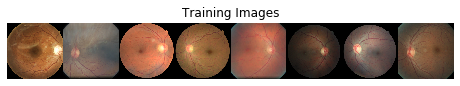

In [8]:
dataloader = load_dataset(params)

sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
   sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## Discriminator, Generator & Parameter Definitions

In [9]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(params['nz'], params['ngf']*8*2,
            kernel_size=5, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(params['ngf']*8*2)
        
        self.tconv2 = nn.ConvTranspose2d(params['ngf']*8*2, params['ngf']*4*2,
            5, 3, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ngf']*4*2)

        self.tconv3 = nn.ConvTranspose2d(params['ngf']*4*2, params['ngf']*2*2,
            5, 3, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ngf']*2*2)

        self.tconv4 = nn.ConvTranspose2d(params['ngf']*2*2, params['ngf']*2,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ngf']*2)

        self.tconv5 = nn.ConvTranspose2d(params['ngf']*2, params['ngf'],
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ngf'])

        self.tconv7 = nn.ConvTranspose2d(params['ngf'], params['nc'],
            4, 2, 1, bias=False)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv7(x))
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(params['nc'], params['ndf'],
            4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(params['ndf'], params['ndf']*2,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ndf']*2)

        self.conv3 = nn.Conv2d(params['ndf']*2, params['ndf']*4,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ndf']*4)

        self.conv4 = nn.Conv2d(params['ndf']*4, params['ndf']*8,
            5, 3, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ndf']*8)

        self.conv5 = nn.Conv2d(params['ndf']*8, params['ndf']*16,
            5, 3, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ndf']*16)

        self.conv6 = nn.Conv2d(params['ndf']*16, 1, 5, 1, 0, bias=False)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.sigmoid(self.conv6(x))

        return x

In [12]:
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv7): ConvTranspose2d(32, 3, kernel_size=(4, 4), 

In [13]:
netD = Discriminator(params).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)


In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

In [15]:
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

In [16]:
# Stores generated images as training progresses.
img_list = []

# Stores generator losses during training.
G_losses = []

# Stores discriminator losses during training.
D_losses = []

iters = 0

## Training

In [17]:
print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    batches_done = 0
    for i, data in enumerate(dataloader, 0):
        batches_done +=1
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        netD.zero_grad()
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label  )
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i%50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, params['nepochs'], i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 250 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type1/model_epoch_{}.pth'.format(epoch+1))

Starting Training Loop...
-------------------------


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/250][1/306]	Loss_D: 1.3606	Loss_G: 16.7373	D(x): 0.4938	D(G(z)): 0.4755 / 0.0000
[1/250][51/306]	Loss_D: 0.1352	Loss_G: 8.5504	D(x): 0.9847	D(G(z)): 0.1068 / 0.0005
[1/250][101/306]	Loss_D: 0.0118	Loss_G: 6.2513	D(x): 0.9997	D(G(z)): 0.0113 / 0.0041
[1/250][151/306]	Loss_D: 0.0223	Loss_G: 6.0041	D(x): 0.9989	D(G(z)): 0.0208 / 0.0143
[1/250][201/306]	Loss_D: 0.1119	Loss_G: 5.9513	D(x): 0.9651	D(G(z)): 0.0662 / 0.0028
[1/250][251/306]	Loss_D: 0.0725	Loss_G: 4.9583	D(x): 0.9943	D(G(z)): 0.0640 / 0.0084
[1/250][301/306]	Loss_D: 0.3892	Loss_G: 3.4018	D(x): 0.9372	D(G(z)): 0.2636 / 0.0443
[2/250][1/306]	Loss_D: 0.8159	Loss_G: 4.6965	D(x): 0.9893	D(G(z)): 0.3991 / 0.0395
[2/250][51/306]	Loss_D: 1.0543	Loss_G: 2.4381	D(x): 0.6504	D(G(z)): 0.3350 / 0.1203
[2/250][101/306]	Loss_D: 0.4805	Loss_G: 2.2660	D(x): 0.7177	D(G(z)): 0.0963 / 0.1685
[2/250][151/306]	Loss_D: 0.6102	Loss_G: 4.0228	D(x): 0.8491	D(G(z)): 0.2878 / 0.0312
[2/250][201/306]	Loss_D: 0.3977	Loss_G: 2.8804	D(x): 0.8321	D(G(z)): 0

[14/250][301/306]	Loss_D: 2.7141	Loss_G: 9.2727	D(x): 0.9999	D(G(z)): 0.7737 / 0.0010
[15/250][1/306]	Loss_D: 0.0526	Loss_G: 7.9332	D(x): 0.9815	D(G(z)): 0.0311 / 0.0044
[15/250][51/306]	Loss_D: 0.0434	Loss_G: 3.2307	D(x): 0.9864	D(G(z)): 0.0285 / 0.1129
[15/250][101/306]	Loss_D: 0.1805	Loss_G: 5.3717	D(x): 0.8994	D(G(z)): 0.0099 / 0.0114
[15/250][151/306]	Loss_D: 0.0824	Loss_G: 7.6617	D(x): 0.9550	D(G(z)): 0.0269 / 0.0026
[15/250][201/306]	Loss_D: 2.3033	Loss_G: 2.1359	D(x): 0.2983	D(G(z)): 0.0023 / 0.5137
[15/250][251/306]	Loss_D: 0.0057	Loss_G: 9.1895	D(x): 0.9967	D(G(z)): 0.0023 / 0.0005
[15/250][301/306]	Loss_D: 0.6247	Loss_G: 2.3020	D(x): 0.6729	D(G(z)): 0.0231 / 0.1504
[16/250][1/306]	Loss_D: 1.5826	Loss_G: 5.7128	D(x): 0.9999	D(G(z)): 0.2264 / 0.0048
[16/250][51/306]	Loss_D: 0.4391	Loss_G: 8.0392	D(x): 1.0000	D(G(z)): 0.2928 / 0.0031
[16/250][101/306]	Loss_D: 0.0093	Loss_G: 5.5546	D(x): 0.9996	D(G(z)): 0.0088 / 0.0098
[16/250][151/306]	Loss_D: 0.0212	Loss_G: 9.2280	D(x): 0.9817

[28/250][201/306]	Loss_D: 0.2950	Loss_G: 8.5606	D(x): 0.9997	D(G(z)): 0.2013 / 0.0015
[28/250][251/306]	Loss_D: 0.0186	Loss_G: 6.8078	D(x): 0.9859	D(G(z)): 0.0041 / 0.0041
[28/250][301/306]	Loss_D: 0.2972	Loss_G: 10.2095	D(x): 0.9998	D(G(z)): 0.1955 / 0.0001
[29/250][1/306]	Loss_D: 0.0147	Loss_G: 7.6129	D(x): 1.0000	D(G(z)): 0.0141 / 0.0023
[29/250][51/306]	Loss_D: 0.0997	Loss_G: 5.2294	D(x): 0.9492	D(G(z)): 0.0400 / 0.0137
[29/250][101/306]	Loss_D: 0.3726	Loss_G: 1.9868	D(x): 0.7425	D(G(z)): 0.0033 / 0.1809
[29/250][151/306]	Loss_D: 0.0399	Loss_G: 6.9828	D(x): 1.0000	D(G(z)): 0.0358 / 0.0034
[29/250][201/306]	Loss_D: 0.0403	Loss_G: 2.0111	D(x): 1.0000	D(G(z)): 0.0379 / 0.3725
[29/250][251/306]	Loss_D: 0.0009	Loss_G: 13.9822	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[29/250][301/306]	Loss_D: 0.3352	Loss_G: 2.6375	D(x): 0.7338	D(G(z)): 0.0028 / 0.1398
[30/250][1/306]	Loss_D: 0.2322	Loss_G: 11.1203	D(x): 1.0000	D(G(z)): 0.1071 / 0.0001
[30/250][51/306]	Loss_D: 0.0081	Loss_G: 6.4887	D(x): 0.9

[42/250][101/306]	Loss_D: 0.0037	Loss_G: 8.6330	D(x): 1.0000	D(G(z)): 0.0036 / 0.0020
[42/250][151/306]	Loss_D: 0.0214	Loss_G: 10.1446	D(x): 0.9807	D(G(z)): 0.0016 / 0.0004
[42/250][201/306]	Loss_D: 0.4372	Loss_G: 2.9349	D(x): 0.7382	D(G(z)): 0.0087 / 0.2868
[42/250][251/306]	Loss_D: 0.1998	Loss_G: 9.0821	D(x): 0.9990	D(G(z)): 0.1280 / 0.0009
[42/250][301/306]	Loss_D: 0.1497	Loss_G: 6.9389	D(x): 0.8710	D(G(z)): 0.0010 / 0.0047
[43/250][1/306]	Loss_D: 0.0573	Loss_G: 11.5949	D(x): 0.9491	D(G(z)): 0.0002 / 0.0001
[43/250][51/306]	Loss_D: 0.2106	Loss_G: 8.3243	D(x): 0.9650	D(G(z)): 0.1466 / 0.0003
[43/250][101/306]	Loss_D: 0.7460	Loss_G: 10.6696	D(x): 0.9992	D(G(z)): 0.4420 / 0.0003
[43/250][151/306]	Loss_D: 0.6171	Loss_G: 10.1899	D(x): 1.0000	D(G(z)): 0.3395 / 0.0002
[43/250][201/306]	Loss_D: 0.2131	Loss_G: 6.9796	D(x): 0.9234	D(G(z)): 0.0986 / 0.0022
[43/250][251/306]	Loss_D: 0.1039	Loss_G: 9.8522	D(x): 0.9083	D(G(z)): 0.0001 / 0.0001
[43/250][301/306]	Loss_D: 0.5848	Loss_G: 16.5448	D(x)

[56/250][1/306]	Loss_D: 0.0002	Loss_G: 14.0805	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[56/250][51/306]	Loss_D: 0.0101	Loss_G: 4.5988	D(x): 1.0000	D(G(z)): 0.0100 / 0.0185
[56/250][101/306]	Loss_D: 0.0327	Loss_G: 9.6344	D(x): 0.9688	D(G(z)): 0.0004 / 0.0006
[56/250][151/306]	Loss_D: 0.0509	Loss_G: 20.6522	D(x): 0.9521	D(G(z)): 0.0000 / 0.0000
[56/250][201/306]	Loss_D: 0.0265	Loss_G: 8.8064	D(x): 0.9747	D(G(z)): 0.0003 / 0.0004
[56/250][251/306]	Loss_D: 0.0195	Loss_G: 16.6567	D(x): 0.9812	D(G(z)): 0.0000 / 0.0000
[56/250][301/306]	Loss_D: 0.2476	Loss_G: 12.8134	D(x): 0.9999	D(G(z)): 0.1682 / 0.0000
[57/250][1/306]	Loss_D: 0.0072	Loss_G: 6.6330	D(x): 1.0000	D(G(z)): 0.0071 / 0.0069
[57/250][51/306]	Loss_D: 1.2343	Loss_G: 18.7439	D(x): 0.9938	D(G(z)): 0.3381 / 0.0000
[57/250][101/306]	Loss_D: 0.2251	Loss_G: 5.2684	D(x): 0.8619	D(G(z)): 0.0077 / 0.0128
[57/250][151/306]	Loss_D: 0.0272	Loss_G: 9.1762	D(x): 0.9771	D(G(z)): 0.0035 / 0.0026
[57/250][201/306]	Loss_D: 0.2351	Loss_G: 10.4877	D(x): 

[69/250][251/306]	Loss_D: 0.0554	Loss_G: 9.9945	D(x): 1.0000	D(G(z)): 0.0501 / 0.0007
[69/250][301/306]	Loss_D: 0.0122	Loss_G: 14.9714	D(x): 0.9880	D(G(z)): 0.0000 / 0.0000
[70/250][1/306]	Loss_D: 0.0182	Loss_G: 21.2250	D(x): 0.9979	D(G(z)): 0.0151 / 0.0059
[70/250][51/306]	Loss_D: 0.0010	Loss_G: 8.4525	D(x): 1.0000	D(G(z)): 0.0009 / 0.0007
[70/250][101/306]	Loss_D: 0.0009	Loss_G: 14.0280	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[70/250][151/306]	Loss_D: 0.0205	Loss_G: 12.3822	D(x): 0.9809	D(G(z)): 0.0006 / 0.0003
[70/250][201/306]	Loss_D: 0.0221	Loss_G: 7.5345	D(x): 1.0000	D(G(z)): 0.0207 / 0.0027
[70/250][251/306]	Loss_D: 0.0016	Loss_G: 13.2110	D(x): 0.9987	D(G(z)): 0.0003 / 0.0002
[70/250][301/306]	Loss_D: 0.0886	Loss_G: 5.6208	D(x): 0.9306	D(G(z)): 0.0061 / 0.0070
[71/250][1/306]	Loss_D: 0.0190	Loss_G: 11.5625	D(x): 0.9995	D(G(z)): 0.0179 / 0.0021
[71/250][51/306]	Loss_D: 0.1003	Loss_G: 18.9165	D(x): 0.9190	D(G(z)): 0.0000 / 0.0000
[71/250][101/306]	Loss_D: 0.0005	Loss_G: 15.3739	D(x)

[83/250][151/306]	Loss_D: 0.0033	Loss_G: 9.4080	D(x): 1.0000	D(G(z)): 0.0032 / 0.0014
[83/250][201/306]	Loss_D: 0.0003	Loss_G: 14.0137	D(x): 0.9998	D(G(z)): 0.0001 / 0.0000
[83/250][251/306]	Loss_D: 0.0009	Loss_G: 9.9008	D(x): 1.0000	D(G(z)): 0.0009 / 0.0007
[83/250][301/306]	Loss_D: 0.0142	Loss_G: 9.4009	D(x): 0.9982	D(G(z)): 0.0119 / 0.0031
[84/250][1/306]	Loss_D: 0.2272	Loss_G: 12.7842	D(x): 0.9997	D(G(z)): 0.1673 / 0.0000
[84/250][51/306]	Loss_D: 0.0013	Loss_G: 9.4861	D(x): 1.0000	D(G(z)): 0.0013 / 0.0011
[84/250][101/306]	Loss_D: 0.0002	Loss_G: 13.0576	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[84/250][151/306]	Loss_D: 0.0483	Loss_G: 9.9653	D(x): 1.0000	D(G(z)): 0.0420 / 0.0002
[84/250][201/306]	Loss_D: 0.0036	Loss_G: 12.8195	D(x): 0.9965	D(G(z)): 0.0001 / 0.0000
[84/250][251/306]	Loss_D: 0.0285	Loss_G: 8.8525	D(x): 0.9990	D(G(z)): 0.0249 / 0.0013
[84/250][301/306]	Loss_D: 0.2121	Loss_G: 12.1369	D(x): 0.9999	D(G(z)): 0.1514 / 0.0002
[85/250][1/306]	Loss_D: 0.0008	Loss_G: 10.8409	D(x):

[97/250][51/306]	Loss_D: 0.3695	Loss_G: 15.9918	D(x): 1.0000	D(G(z)): 0.2046 / 0.0000
[97/250][101/306]	Loss_D: 0.0019	Loss_G: 8.2463	D(x): 0.9997	D(G(z)): 0.0015 / 0.0014
[97/250][151/306]	Loss_D: 0.7278	Loss_G: 12.8473	D(x): 0.7117	D(G(z)): 0.0000 / 0.0672
[97/250][201/306]	Loss_D: 0.0027	Loss_G: 15.4741	D(x): 0.9973	D(G(z)): 0.0000 / 0.0000
[97/250][251/306]	Loss_D: 0.0135	Loss_G: 6.9740	D(x): 1.0000	D(G(z)): 0.0132 / 0.0022
[97/250][301/306]	Loss_D: 0.1253	Loss_G: 9.7742	D(x): 1.0000	D(G(z)): 0.1085 / 0.0005
[98/250][1/306]	Loss_D: 0.0000	Loss_G: 14.6202	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[98/250][51/306]	Loss_D: 0.2288	Loss_G: 18.4849	D(x): 0.8629	D(G(z)): 0.0014 / 0.0042
[98/250][101/306]	Loss_D: 0.0003	Loss_G: 12.9654	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[98/250][151/306]	Loss_D: 0.1309	Loss_G: 14.7298	D(x): 1.0000	D(G(z)): 0.1057 / 0.0018
[98/250][201/306]	Loss_D: 0.0000	Loss_G: 19.0648	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[98/250][251/306]	Loss_D: 0.0001	Loss_G: 12.8489	D

[110/250][251/306]	Loss_D: 0.0384	Loss_G: 7.2671	D(x): 0.9997	D(G(z)): 0.0345 / 0.0016
[110/250][301/306]	Loss_D: 0.0475	Loss_G: 9.8168	D(x): 0.9998	D(G(z)): 0.0418 / 0.0005
[111/250][1/306]	Loss_D: 0.0021	Loss_G: 7.7910	D(x): 1.0000	D(G(z)): 0.0021 / 0.0021
[111/250][51/306]	Loss_D: 0.0118	Loss_G: 10.8898	D(x): 1.0000	D(G(z)): 0.0114 / 0.0003
[111/250][101/306]	Loss_D: 0.0177	Loss_G: 9.3258	D(x): 0.9999	D(G(z)): 0.0167 / 0.0064
[111/250][151/306]	Loss_D: 0.0682	Loss_G: 11.1435	D(x): 0.9490	D(G(z)): 0.0062 / 0.0032
[111/250][201/306]	Loss_D: 0.0000	Loss_G: 13.0799	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[111/250][251/306]	Loss_D: 0.0000	Loss_G: 11.8659	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[111/250][301/306]	Loss_D: 0.3362	Loss_G: 14.8187	D(x): 0.7710	D(G(z)): 0.0000 / 0.0006
[112/250][1/306]	Loss_D: 0.0054	Loss_G: 18.3589	D(x): 1.0000	D(G(z)): 0.0053 / 0.0089
[112/250][51/306]	Loss_D: 0.0027	Loss_G: 7.8937	D(x): 1.0000	D(G(z)): 0.0026 / 0.0018
[112/250][101/306]	Loss_D: 0.0004	Loss_G: 1

[124/250][101/306]	Loss_D: 0.0009	Loss_G: 24.9023	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[124/250][151/306]	Loss_D: 0.2281	Loss_G: 14.6044	D(x): 0.8332	D(G(z)): 0.0000 / 0.0000
[124/250][201/306]	Loss_D: 0.0135	Loss_G: 20.2840	D(x): 0.9870	D(G(z)): 0.0000 / 0.0000
[124/250][251/306]	Loss_D: 0.0000	Loss_G: 21.8449	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[124/250][301/306]	Loss_D: 0.0001	Loss_G: 23.5112	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[125/250][1/306]	Loss_D: 0.0471	Loss_G: 11.1284	D(x): 1.0000	D(G(z)): 0.0395 / 0.0006
[125/250][51/306]	Loss_D: 0.0038	Loss_G: 11.6627	D(x): 1.0000	D(G(z)): 0.0038 / 0.0012
[125/250][101/306]	Loss_D: 0.0602	Loss_G: 8.6179	D(x): 0.9991	D(G(z)): 0.0537 / 0.0007
[125/250][151/306]	Loss_D: 0.0349	Loss_G: 10.4612	D(x): 0.9999	D(G(z)): 0.0326 / 0.0025
[125/250][201/306]	Loss_D: 0.0010	Loss_G: 8.7612	D(x): 1.0000	D(G(z)): 0.0009 / 0.0008
[125/250][251/306]	Loss_D: 0.0003	Loss_G: 9.4161	D(x): 1.0000	D(G(z)): 0.0003 / 0.0002
[125/250][301/306]	Loss_D: 0.0089	Loss

[137/250][251/306]	Loss_D: 0.0001	Loss_G: 18.5545	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[137/250][301/306]	Loss_D: 0.0061	Loss_G: 11.3532	D(x): 0.9944	D(G(z)): 0.0004 / 0.0002
[138/250][1/306]	Loss_D: 0.0023	Loss_G: 8.4252	D(x): 0.9989	D(G(z)): 0.0012 / 0.0014
[138/250][51/306]	Loss_D: 0.0526	Loss_G: 7.8794	D(x): 0.9968	D(G(z)): 0.0465 / 0.0006
[138/250][101/306]	Loss_D: 0.0001	Loss_G: 14.1794	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[138/250][151/306]	Loss_D: 0.0011	Loss_G: 23.2664	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[138/250][201/306]	Loss_D: 0.0002	Loss_G: 11.6420	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[138/250][251/306]	Loss_D: 0.0020	Loss_G: 14.7057	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000
[138/250][301/306]	Loss_D: 0.0205	Loss_G: 17.7334	D(x): 1.0000	D(G(z)): 0.0198 / 0.0004
[139/250][1/306]	Loss_D: 0.2461	Loss_G: 25.0379	D(x): 1.0000	D(G(z)): 0.1246 / 0.0000
[139/250][51/306]	Loss_D: 0.7829	Loss_G: 13.6238	D(x): 0.7427	D(G(z)): 0.0000 / 0.0005
[139/250][101/306]	Loss_D: 0.0004	Loss_G

[151/250][51/306]	Loss_D: 0.0001	Loss_G: 13.6922	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[151/250][101/306]	Loss_D: 0.0004	Loss_G: 12.2099	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[151/250][151/306]	Loss_D: 0.0001	Loss_G: 12.2151	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[151/250][201/306]	Loss_D: 0.0314	Loss_G: 18.5776	D(x): 0.9707	D(G(z)): 0.0000 / 0.0000
[151/250][251/306]	Loss_D: 0.0015	Loss_G: 11.7794	D(x): 1.0000	D(G(z)): 0.0015 / 0.0013
[151/250][301/306]	Loss_D: 0.0455	Loss_G: 6.6442	D(x): 1.0000	D(G(z)): 0.0391 / 0.0045
[152/250][1/306]	Loss_D: 0.0150	Loss_G: 5.7664	D(x): 0.9986	D(G(z)): 0.0135 / 0.0037
[152/250][51/306]	Loss_D: 0.0017	Loss_G: 9.5457	D(x): 1.0000	D(G(z)): 0.0017 / 0.0055
[152/250][101/306]	Loss_D: 0.4193	Loss_G: 16.2497	D(x): 0.9979	D(G(z)): 0.2054 / 0.0000
[152/250][151/306]	Loss_D: 0.0050	Loss_G: 6.3995	D(x): 1.0000	D(G(z)): 0.0049 / 0.0027
[152/250][201/306]	Loss_D: 0.0008	Loss_G: 9.2898	D(x): 1.0000	D(G(z)): 0.0008 / 0.0005
[152/250][251/306]	Loss_D: 0.0000	Loss_G:

[164/250][201/306]	Loss_D: 0.0002	Loss_G: 11.4087	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[164/250][251/306]	Loss_D: 0.0308	Loss_G: 19.8314	D(x): 1.0000	D(G(z)): 0.0273 / 0.0001
[164/250][301/306]	Loss_D: 0.1080	Loss_G: 30.4451	D(x): 0.9029	D(G(z)): 0.0000 / 0.0000
[165/250][1/306]	Loss_D: 0.0001	Loss_G: 24.1932	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[165/250][51/306]	Loss_D: 0.0004	Loss_G: 19.6337	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[165/250][101/306]	Loss_D: 0.0870	Loss_G: 10.7173	D(x): 0.9968	D(G(z)): 0.0727 / 0.0006
[165/250][151/306]	Loss_D: 0.0000	Loss_G: 18.3851	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[165/250][201/306]	Loss_D: 0.0002	Loss_G: 13.0444	D(x): 1.0000	D(G(z)): 0.0002 / 0.0003
[165/250][251/306]	Loss_D: 0.0004	Loss_G: 9.6535	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[165/250][301/306]	Loss_D: 0.0008	Loss_G: 17.4811	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[166/250][1/306]	Loss_D: 0.4670	Loss_G: 32.6483	D(x): 0.8521	D(G(z)): 0.0000 / 0.0000
[166/250][51/306]	Loss_D: 0.0014	Loss_

[178/250][1/306]	Loss_D: 0.0022	Loss_G: 25.6385	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000
[178/250][51/306]	Loss_D: 0.0001	Loss_G: 22.0180	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[178/250][101/306]	Loss_D: 0.0429	Loss_G: 11.2807	D(x): 1.0000	D(G(z)): 0.0364 / 0.0004
[178/250][151/306]	Loss_D: 0.0009	Loss_G: 8.5569	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006
[178/250][201/306]	Loss_D: 0.0865	Loss_G: 8.7087	D(x): 1.0000	D(G(z)): 0.0759 / 0.0012
[178/250][251/306]	Loss_D: 0.0003	Loss_G: 10.2000	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[178/250][301/306]	Loss_D: 0.0072	Loss_G: 30.6482	D(x): 0.9930	D(G(z)): 0.0000 / 0.0000
[179/250][1/306]	Loss_D: 0.9856	Loss_G: 23.1547	D(x): 0.6122	D(G(z)): 0.0039 / 0.1765
[179/250][51/306]	Loss_D: 0.0216	Loss_G: 25.0965	D(x): 0.9794	D(G(z)): 0.0000 / 0.0000
[179/250][101/306]	Loss_D: 0.0006	Loss_G: 8.3468	D(x): 1.0000	D(G(z)): 0.0006 / 0.0016
[179/250][151/306]	Loss_D: 0.2547	Loss_G: 12.9752	D(x): 0.8657	D(G(z)): 0.0000 / 0.0000
[179/250][201/306]	Loss_D: 0.0001	Loss_G:

[191/250][151/306]	Loss_D: 0.0001	Loss_G: 14.0725	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[191/250][201/306]	Loss_D: 0.0026	Loss_G: 8.3771	D(x): 1.0000	D(G(z)): 0.0025 / 0.0013
[191/250][251/306]	Loss_D: 0.0021	Loss_G: 8.6793	D(x): 1.0000	D(G(z)): 0.0020 / 0.0011
[191/250][301/306]	Loss_D: 0.0000	Loss_G: 15.4114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[192/250][1/306]	Loss_D: 0.0000	Loss_G: 17.4733	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[192/250][51/306]	Loss_D: 0.0059	Loss_G: 9.6043	D(x): 0.9952	D(G(z)): 0.0010 / 0.0010
[192/250][101/306]	Loss_D: 0.0000	Loss_G: 14.6306	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[192/250][151/306]	Loss_D: 0.0355	Loss_G: 7.1650	D(x): 1.0000	D(G(z)): 0.0331 / 0.0021
[192/250][201/306]	Loss_D: 0.0047	Loss_G: 14.1843	D(x): 1.0000	D(G(z)): 0.0046 / 0.0031
[192/250][251/306]	Loss_D: 0.0004	Loss_G: 9.6035	D(x): 1.0000	D(G(z)): 0.0004 / 0.0002
[192/250][301/306]	Loss_D: 0.0000	Loss_G: 27.7502	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[193/250][1/306]	Loss_D: 0.0000	Loss_G: 

[204/250][301/306]	Loss_D: 0.0659	Loss_G: 19.5326	D(x): 0.9466	D(G(z)): 0.0000 / 0.0000
[205/250][1/306]	Loss_D: 0.0079	Loss_G: 6.9256	D(x): 1.0000	D(G(z)): 0.0078 / 0.0040
[205/250][51/306]	Loss_D: 0.0017	Loss_G: 9.6875	D(x): 0.9998	D(G(z)): 0.0015 / 0.0010
[205/250][101/306]	Loss_D: 0.0095	Loss_G: 23.7586	D(x): 0.9908	D(G(z)): 0.0000 / 0.0000
[205/250][151/306]	Loss_D: 0.0214	Loss_G: 9.9459	D(x): 1.0000	D(G(z)): 0.0205 / 0.0136
[205/250][201/306]	Loss_D: 0.0007	Loss_G: 15.6714	D(x): 1.0000	D(G(z)): 0.0007 / 0.0003
[205/250][251/306]	Loss_D: 0.0000	Loss_G: 12.9765	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[205/250][301/306]	Loss_D: 0.0017	Loss_G: 12.7404	D(x): 1.0000	D(G(z)): 0.0017 / 0.0017
[206/250][1/306]	Loss_D: 0.0001	Loss_G: 17.9006	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[206/250][51/306]	Loss_D: 0.0000	Loss_G: 19.3052	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[206/250][101/306]	Loss_D: 0.0015	Loss_G: 18.4347	D(x): 1.0000	D(G(z)): 0.0015 / 0.0012
[206/250][151/306]	Loss_D: 0.0566	Loss_G:

[218/250][101/306]	Loss_D: 0.0000	Loss_G: 17.7789	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[218/250][151/306]	Loss_D: 0.0000	Loss_G: 17.7710	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[218/250][201/306]	Loss_D: 0.2208	Loss_G: 15.2630	D(x): 1.0000	D(G(z)): 0.1476 / 0.0000
[218/250][251/306]	Loss_D: 0.1558	Loss_G: 9.9472	D(x): 1.0000	D(G(z)): 0.1400 / 0.0001
[218/250][301/306]	Loss_D: 0.0013	Loss_G: 8.1946	D(x): 1.0000	D(G(z)): 0.0013 / 0.0010
[219/250][1/306]	Loss_D: 0.0000	Loss_G: 17.0937	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[219/250][51/306]	Loss_D: 0.0002	Loss_G: 31.5107	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[219/250][101/306]	Loss_D: 0.0017	Loss_G: 20.6960	D(x): 1.0000	D(G(z)): 0.0017 / 0.0016
[219/250][151/306]	Loss_D: 0.0053	Loss_G: 8.8651	D(x): 1.0000	D(G(z)): 0.0053 / 0.0028
[219/250][201/306]	Loss_D: 0.0001	Loss_G: 12.5783	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[219/250][251/306]	Loss_D: 0.0001	Loss_G: 14.1113	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[219/250][301/306]	Loss_D: 0.0001	Loss

[234/250][201/306]	Loss_D: 0.0001	Loss_G: 12.5063	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[234/250][251/306]	Loss_D: 0.0002	Loss_G: 17.8543	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[234/250][301/306]	Loss_D: 0.0199	Loss_G: 20.5245	D(x): 0.9875	D(G(z)): 0.0068 / 0.0062
[235/250][1/306]	Loss_D: 0.1235	Loss_G: 23.6375	D(x): 1.0000	D(G(z)): 0.0846 / 0.0000
[235/250][51/306]	Loss_D: 0.0114	Loss_G: 10.2784	D(x): 1.0000	D(G(z)): 0.0111 / 0.0037
[235/250][101/306]	Loss_D: 0.0000	Loss_G: 14.9756	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[235/250][151/306]	Loss_D: 0.0074	Loss_G: 20.6226	D(x): 0.9999	D(G(z)): 0.0071 / 0.0020
[235/250][201/306]	Loss_D: 0.0879	Loss_G: 25.0948	D(x): 0.9300	D(G(z)): 0.0000 / 0.0000
[235/250][251/306]	Loss_D: 0.0121	Loss_G: 6.9109	D(x): 1.0000	D(G(z)): 0.0118 / 0.0043
[235/250][301/306]	Loss_D: 0.0055	Loss_G: 7.0188	D(x): 1.0000	D(G(z)): 0.0054 / 0.0036
[236/250][1/306]	Loss_D: 0.0052	Loss_G: 8.1832	D(x): 1.0000	D(G(z)): 0.0051 / 0.0297
[236/250][51/306]	Loss_D: 0.0278	Loss_G:

[248/250][1/306]	Loss_D: 0.0000	Loss_G: 65.3527	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[248/250][51/306]	Loss_D: 0.0000	Loss_G: 60.5715	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[248/250][101/306]	Loss_D: 0.0000	Loss_G: 70.1223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[248/250][151/306]	Loss_D: 0.0000	Loss_G: 70.3047	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[248/250][201/306]	Loss_D: 0.0000	Loss_G: 62.1274	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[248/250][251/306]	Loss_D: 0.0000	Loss_G: 63.5354	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[248/250][301/306]	Loss_D: 0.0000	Loss_G: 69.2850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[249/250][1/306]	Loss_D: 0.0000	Loss_G: 63.3632	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[249/250][51/306]	Loss_D: 0.0000	Loss_G: 59.4947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[249/250][101/306]	Loss_D: 0.0000	Loss_G: 63.2454	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[249/250][151/306]	Loss_D: 0.0000	Loss_G: 64.4328	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[249/250][201/306]	Loss_D: 0.0000	Loss

In [21]:
# Final Trained Model.

torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type1/model_final.pth')

In [19]:
with open('model/type1/G_losses_type1.json', 'w') as f:
    json.dump(G_losses, f)

with open('model/type1/D_losses_type1.json', 'w') as f:
    json.dump(D_losses, f)

### Discriminator vs Generator Loss Plot

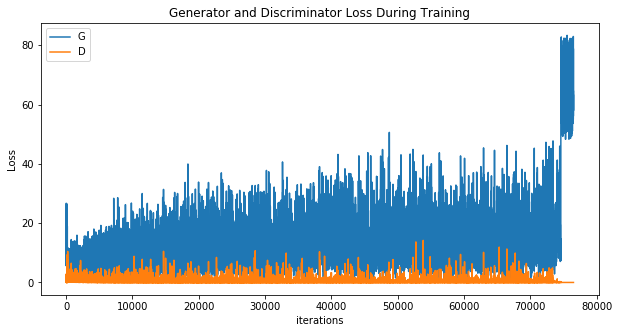

In [20]:
# Plot the Training Losses.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./generated_images/type1/discriminator_generator_loss_plot_type1.png')
plt.show()

## Sample Generation from Trained Model

### Sample from each Epochs

In [22]:
with tqdm(params['nepochs']) as pbar:
    for epoch in range(0,params['nepochs'],5):
        path = f'model/type1/model_epoch_{epoch+1}.pth'
        state_dict = torch.load(path,map_location='cpu')

        device = torch.device("cuda")
        params = state_dict['params']

        netG = Generator(params).to(device)
        netG.load_state_dict(state_dict['generator'])

        for i in range(10):
            noise = torch.randn(1, params['nz'], 1, 1, device=device)

            with torch.no_grad():
                generated_img = netG(noise).detach().cpu()

            image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
            plt.imsave(fname=f'./generated_images/type1/pic_generated_{epoch}_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(5)

250it [01:26,  2.89it/s]


### Samples from Final Epoch

In [23]:
path = f'model/type1/model_final.pth'
state_dict = torch.load(path,map_location='cpu')
device = torch.device("cuda")
params = state_dict['params']

netG = Generator(params).to(device)
netG.load_state_dict(state_dict['generator'])

with tqdm(1000) as pbar:
    for i in range(1000):
        noise = torch.randn(1, params['nz'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(noise).detach().cpu()
        
        image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
        plt.imsave(fname=f'./generated_images/1_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(1)

1000it [01:23, 12.04it/s]


### Learning Transitions across Epochs (Animation)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


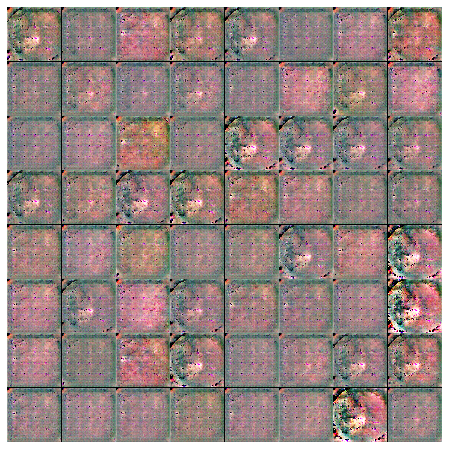

In [24]:
# Animation showing the overall improvements of the generator during the training.

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type1/fundus_type1.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


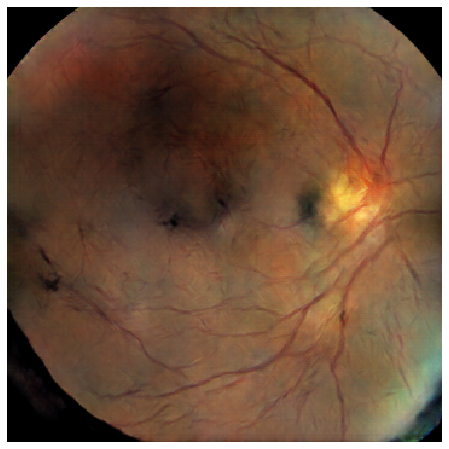

In [25]:
# Animation showing the improvements of the generator for across epoch from generated samples.

img_list = map(plt.imread, sorted(glob.glob('./generated_images/type1/*10.png')))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type1/fundus_type1_1.gif', dpi=80, writer='imagemagick')